Link to my Blogpost (Deliverable):
https://drive.google.com/open?id=1LOVdk62rwNGV4cqomaGrc9LA_fT570ATbvLRo7fBBeo

Installation of packages

In [17]:
pip install -U pandasql

Requirement already up-to-date: pandasql in /usr/local/lib/python3.6/dist-packages (0.7.3)


In [18]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u252-b09-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2


In [0]:
import pandas as pd
from pandasql import sqldf
import dateutil.parser
from datetime import datetime
pysqldf = lambda q: sqldf(q, globals())

Reading and Cleaning Data

In [20]:
otp_df =pd.read_csv('/content/drive/My Drive/CIS545Project/otp.csv')
original_otp_df = pd.DataFrame(otp_df)
otp_df

,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35
...,...,...,...,...,...,...,...
1882010,3520,N,Elwyn,University City,2016-11-06,12 min,2016-11-06 12:16:59
1882011,215,S,Elm,Allegheny,2016-11-06,7 min,2016-11-06 12:17:01
1882012,214,N,None,None,2016-11-06,On Time,2016-11-06 12:17:01
1882013,5338,N,None,None,2016-11-06,On Time,2016-11-06 12:17:02


In [21]:
otp_df = otp_df[otp_df.train_id.apply(lambda x: x.isnumeric())]
otp_df['train_id'] = otp_df['train_id'].astype(str).astype(int)
otp_df = otp_df[otp_df['origin'] != 'None']
otp_df = otp_df[otp_df['next_station'] != 'None']
otp_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35
...,...,...,...,...,...,...,...
1882008,5317,S,Doylestown,Delaware Valley College,2016-11-06,1 min,2016-11-06 12:16:59
1882009,3535,S,West Trenton Yard,Neshaminy Falls,2016-11-06,On Time,2016-11-06 12:16:59
1882010,3520,N,Elwyn,University City,2016-11-06,12 min,2016-11-06 12:16:59
1882011,215,S,Elm,Allegheny,2016-11-06,7 min,2016-11-06 12:17:01


In [22]:
otp_df = otp_df[otp_df['status'] != '999 min']
otp_df = otp_df[otp_df['status'] != '1440 min']
otp_df['status'] = otp_df['status'].apply(lambda x: 0 if (x == 'On Time') else x[0:-4])
otp_df['status'] = otp_df['status'].astype(str).astype(int)
otp_df

,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,0,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,0,2016-03-23 00:03:35
...,...,...,...,...,...,...,...
1882008,5317,S,Doylestown,Delaware Valley College,2016-11-06,1,2016-11-06 12:16:59
1882009,3535,S,West Trenton Yard,Neshaminy Falls,2016-11-06,0,2016-11-06 12:16:59
1882010,3520,N,Elwyn,University City,2016-11-06,12,2016-11-06 12:16:59
1882011,215,S,Elm,Allegheny,2016-11-06,7,2016-11-06 12:17:01


Feature Extraction

In [23]:
otp_df['timeStamp'] = otp_df['timeStamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
otp_df['weekday'] = otp_df['timeStamp'].apply(lambda x: x.weekday())
otp_df['hour'] = otp_df['timeStamp'].dt.hour
otp_df

,train_id,direction,origin,next_station,date,status,timeStamp,weekday,hour
0,778,N,Trenton,Stenton,2016-03-23,1,2016-03-23 00:01:47,2,0
1,598,N,Thorndale,Narberth,2016-03-23,1,2016-03-23 00:01:58,2,0
2,279,S,Elm,Ridley Park,2016-03-23,2,2016-03-23 00:02:02,2,0
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,0,2016-03-23 00:03:19,2,0
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,0,2016-03-23 00:03:35,2,0
...,...,...,...,...,...,...,...,...,...
1882008,5317,S,Doylestown,Delaware Valley College,2016-11-06,1,2016-11-06 12:16:59,6,12
1882009,3535,S,West Trenton Yard,Neshaminy Falls,2016-11-06,0,2016-11-06 12:16:59,6,12
1882010,3520,N,Elwyn,University City,2016-11-06,12,2016-11-06 12:16:59,6,12
1882011,215,S,Elm,Allegheny,2016-11-06,7,2016-11-06 12:17:01,6,12


Exploratory Data Analysis for Overall Data

In [0]:
q = """SELECT weekday, AVG(status) AS average_delay
    FROM otp_df
    GROUP BY weekday"""
result = pysqldf(q)
result

,weekday,average_delay
0,0,4.639625
1,1,4.904372
2,2,4.344884
3,3,4.271655
4,4,4.418696
5,5,3.820818
6,6,3.331030


<Figure size 432x288 with 0 Axes>

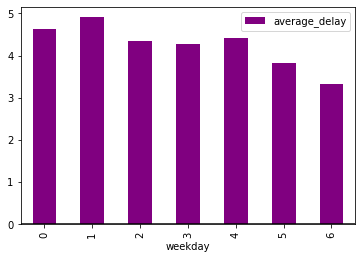

In [0]:
import matplotlib.pyplot as plt
plt.figure();
result.plot(kind='bar', x = 'weekday', y = 'average_delay', color = 'purple'); plt.axhline(0, color='k')
plt.show()

In [0]:
q = """WITH A AS(
    SELECT weekday, COUNT(status) AS on_time
    FROM otp_df
    WHERE status = 0
    GROUP BY weekday),
    B AS(
    SELECT weekday, COUNT(status) AS delay
    FROM otp_df
    WHERE status != 0
    GROUP BY weekday)
    SELECT A.weekday, on_time, delay
    FROM A JOIN B ON A.weekday = B.weekday"""
result = pysqldf(q)
result

,weekday,on_time,delay
0,0,71987,188791
1,1,75093,197265
2,2,81614,202818
3,3,83091,200927
4,4,78742,203637
5,5,62049,139378
6,6,60716,116730


Text(0, 0.5, 'Number of Trains')

<Figure size 432x288 with 0 Axes>

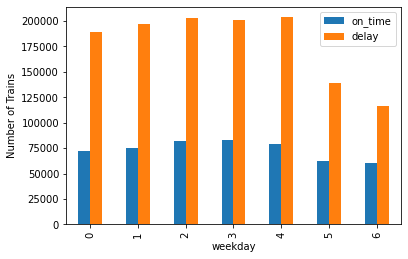

In [0]:
plt.figure()
result.plot(kind = 'bar', x = 'weekday')
plt.ylabel('Number of Trains')

In [0]:
q = """SELECT direction, COUNT(status) AS number_of_delays
    FROM otp_df
    WHERE status > 0
    GROUP BY direction"""
result = pysqldf(q)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fae9034b978>],
      dtype=object)

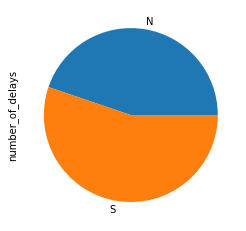

In [0]:
result = result.set_index('direction')
result['number_of_delays'].plot.pie(subplots=True, figsize=(8, 4))

In [0]:
q = """SELECT hour, AVG(status) AS average_delay
    FROM otp_df
    GROUP BY hour"""
result1 = pysqldf(q)
result1

,hour,average_delay
0,0,3.370803
1,1,2.684603
2,2,4.833982
3,3,9.142857
4,4,1.222108
5,5,1.729134
6,6,2.577008
7,7,3.438917
8,8,4.901750
9,9,5.511527


Text(0, 0.5, 'average_delay (in minutes)')

<Figure size 432x288 with 0 Axes>

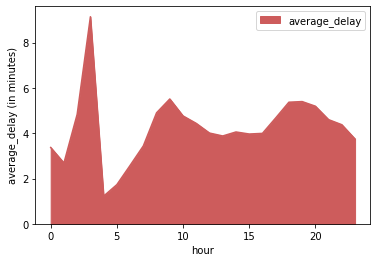

In [0]:
plt.figure()
result1.plot(kind='area', x='hour', y='average_delay', color = 'indianred');
plt.xlabel('hour')
plt.ylabel('average_delay (in minutes)')

In [0]:
q = """SELECT origin, AVG(status) AS average_delay
    FROM otp_df
    GROUP BY origin
    ORDER BY AVG(status) DESC LIMIT 5"""
result2 = pysqldf(q)
result2

,origin,average_delay
0,Chalfont,36.857143
1,Stenton,35.090909
2,Whitford,34.750000
3,Rydal,34.068966
4,Allegheny,29.250000


<Figure size 432x288 with 0 Axes>

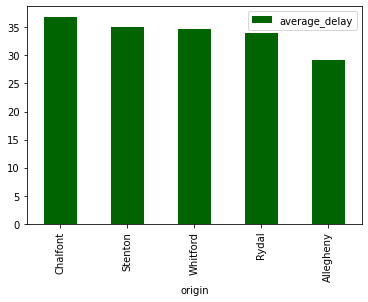

In [0]:
plt.figure()
result2.plot(kind = 'bar', x = 'origin',y='average_delay',color = 'darkgreen')

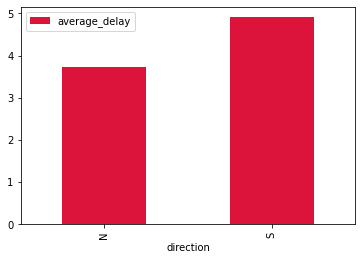

In [13]:
q = """SELECT direction, AVG(status) AS average_delay
    FROM otp_df
    GROUP BY direction"""
result = pysqldf(q)
result.plot(kind = 'bar', x = 'direction' , y = 'average_delay', color = 'crimson')

Exploring the machine learning label

In [0]:
print(otp_df['status'].describe())

count    1.762838e+06
mean     4.313016e+00
std      6.508862e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      1.730000e+02
Name: status, dtype: float64


Exploratory Data Analysis for University City Station

In [8]:
station_df = otp_df[otp_df['next_station'] == 'University City']
station_df

,train_id,direction,origin,next_station,date,status,timeStamp,weekday,hour
10,9264,N,Marcus Hook,University City,2016-03-23,0,2016-03-23 00:05:02,2,0
51,395,S,Trent,University City,2016-03-23,0,2016-03-23 00:20:17,2,0
63,478,N,Airport Terminal E-F,University City,2016-03-23,0,2016-03-23 00:24:20,2,0
175,9266,N,Wilmington,University City,2016-03-23,1,2016-03-23 01:27:41,2,1
208,401,S,Fern Rock TC,University City,2016-03-23,0,2016-03-23 04:31:16,2,4
...,...,...,...,...,...,...,...,...,...
1881781,5313,S,Doylestown,University City,2016-11-06,5,2016-11-06 11:44:55,6,11
1881842,426,N,Airport Terminal E-F,University City,2016-11-06,0,2016-11-06 11:55:15,6,11
1881918,7429,S,Chestnut Hill East,University City,2016-11-06,5,2016-11-06 12:06:14,6,12
1881993,212,N,Marcus Hook,University City,2016-11-06,0,2016-11-06 12:16:46,6,12


Text(0, 0.5, 'Average Delay (In Minutes)')

<Figure size 432x288 with 0 Axes>

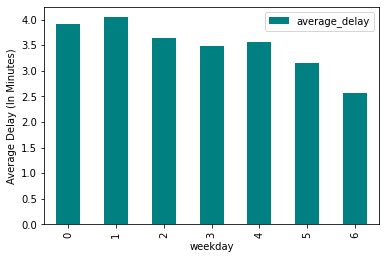

In [10]:
import matplotlib.pyplot as plt
q = """SELECT weekday, AVG(status) AS average_delay
    FROM station_df
    GROUP BY weekday"""
result = pysqldf(q)
plt.figure()
result.plot(kind = 'bar', x = 'weekday' , y = 'average_delay', color = 'teal')
plt.ylabel('Average Delay (In Minutes)')

In [12]:
covariance_df = station_df[['status','weekday','hour']]
corr_matrix = covariance_df.corr()
corr_matrix.style.background_gradient()

,status,weekday,hour
status,1.000000,-0.066425,0.022997
weekday,-0.066425,1.000000,0.009861
hour,0.022997,0.009861,1.000000


Text(0, 0.5, 'Average Delay (In Minutes)')

<Figure size 432x288 with 0 Axes>

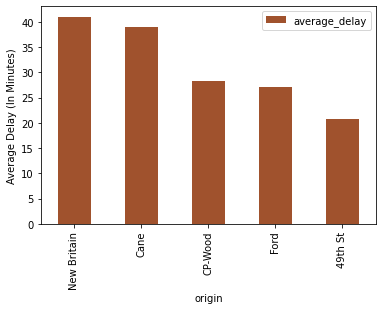

In [16]:
q = """SELECT origin, AVG(status) AS average_delay
    FROM station_df
    GROUP BY origin
    ORDER BY average_delay DESC LIMIT 5"""
result = pysqldf(q)
plt.figure()
result.plot(kind = 'bar', x = 'origin' , y = 'average_delay', color = 'sienna')
plt.ylabel('Average Delay (In Minutes)')

Exploratory Data Analysis for Train 395

Text(0, 0.5, 'average_delay (in minutes)')

<Figure size 432x288 with 0 Axes>

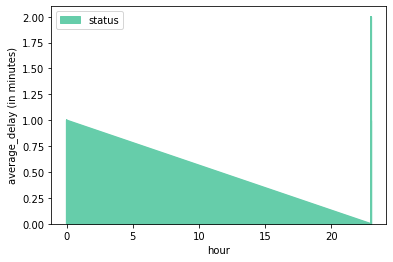

In [26]:
q = """SELECT hour, status
    FROM otp_df
    WHERE train_id = 395 AND DATE = '2016-04-08'"""
result = pysqldf(q)
result
plt.figure()
result.plot(kind='area', x='hour', y='status', color = 'mediumaquamarine');
plt.xlabel('hour')
plt.ylabel('average_delay (in minutes)')

In [27]:
q = """SELECT next_station, status
    FROM otp_df
    WHERE train_id = 395
    ORDER BY timeStamp"""
result = pysqldf(q)
result

,next_station,status
0,Temple U,0
1,Jefferson Station,1
2,Suburban Station,0
3,30th Street Station,0
4,University City,0
...,...,...
1835,Temple U,4
1836,Jefferson Station,5
1837,Suburban Station,5
1838,30th Street Station,4


In [28]:
result['status_diff'] = result['status'].diff()
result

,next_station,status,status_diff
0,Temple U,0,NaN
1,Jefferson Station,1,1.0
2,Suburban Station,0,-1.0
3,30th Street Station,0,0.0
4,University City,0,0.0
...,...,...,...
1835,Temple U,4,0.0
1836,Jefferson Station,5,1.0
1837,Suburban Station,5,0.0
1838,30th Street Station,4,-1.0


In [29]:
q = """SELECT next_station, AVG(status_diff) AS incremental_contribution
    FROM result
    WHERE status_diff != 'NaN'
    GROUP BY next_station"""
result = pysqldf(q)
result

,next_station,incremental_contribution
0,30th Street Station,-0.210526
1,Bethayres,-0.680851
2,Fern Rock TC,0.747899
3,Forest Hills,-1.053191
4,Jefferson Station,0.978723
5,Jenkintown-Wyncote,0.255319
6,Langhorne,-0.042553
7,Meadowbrook,-0.063158
8,Neshaminy Falls,-0.138298
9,Noble,-0.397849


One Hot Encoding For Machine Learning Purposes

In [60]:
otp_df = pd.get_dummies(otp_df, columns = ['direction','origin','next_station'])
otp_df

,train_id,date,status,timeStamp,weekday,hour,direction_N,direction_S,origin_16th St Jct,origin_20th St,origin_30th South,origin_30th Street Station,origin_49th St,origin_60th St North,origin_9th St,origin_Airport Jct,origin_Airport Terminal A,origin_Airport Terminal B,origin_Airport Terminal C-D,origin_Airport Terminal E-F,origin_Allegheny,origin_Allen Lane,origin_Ambler,origin_Angora,origin_Ardsley,origin_Arsenal,origin_Bala,origin_Bethayres,origin_Bridge,origin_Broad,origin_Bryn Mawr,origin_Bryn Mawr Int,origin_CP-North Elwyn,origin_CP-Wood,origin_Cane,origin_Carmel,origin_Carmel South,origin_Carpenter,origin_Chalfont,origin_Chelt,...,next_station_Roslyn,next_station_Rydal,next_station_Ryers,next_station_Secane,next_station_Sedgwick,next_station_Sharon Hill,next_station_Somerton,next_station_Spring Mill,next_station_St. Davids,next_station_St. Martins,next_station_Stenton,next_station_Strafford,next_station_Suburban Station,next_station_Swarthmore,next_station_Tacony,next_station_Temple U,next_station_Thorndale,next_station_Torresdale,next_station_Trenton,next_station_Trevose,next_station_Tulpehocken,next_station_University City,next_station_Upsal,next_station_Villanova,next_station_Wallingford,next_station_Warminster,next_station_Washington Lane,next_station_Wayne Jct,next_station_Wayne-A,next_station_West Trenton,next_station_Whitford,next_station_Willow Grove,next_station_Wilmington,next_station_Wissahickon,next_station_Wister,next_station_Woodbourne,next_station_Wyndmoor,next_station_Wynnefield Avenue,next_station_Wynnewood,next_station_Yardley
0,778,2016-03-23,1,2016-03-23 00:01:47,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,598,2016-03-23,1,2016-03-23 00:01:58,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,279,2016-03-23,2,2016-03-23 00:02:02,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,476,2016-03-23,0,2016-03-23 00:03:19,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,474,2016-03-23,0,2016-03-23 00:03:35,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882008,5317,2016-11-06,1,2016-11-06 12:16:59,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882009,3535,2016-11-06,0,2016-11-06 12:16:59,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882010,3520,2016-11-06,12,2016-11-06 12:16:59,6,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882011,215,2016-11-06,7,2016-11-06 12:17:01,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Use these cells to convert status into categorical variable

In [61]:
otp_df['status'] = otp_df['status'].apply(lambda x: 0 if (x <= 2) else 1)
otp_df['status']

0          0
1          0
2          0
3          0
4          0
          ..
1882008    0
1882009    0
1882010    1
1882011    1
1882014    1
Name: status, Length: 1762838, dtype: int64

In [62]:
categorical_data = otp_df.drop(columns = ['timeStamp','date'], axis = 1)
categorical_data

,train_id,status,weekday,hour,direction_N,direction_S,origin_16th St Jct,origin_20th St,origin_30th South,origin_30th Street Station,origin_49th St,origin_60th St North,origin_9th St,origin_Airport Jct,origin_Airport Terminal A,origin_Airport Terminal B,origin_Airport Terminal C-D,origin_Airport Terminal E-F,origin_Allegheny,origin_Allen Lane,origin_Ambler,origin_Angora,origin_Ardsley,origin_Arsenal,origin_Bala,origin_Bethayres,origin_Bridge,origin_Broad,origin_Bryn Mawr,origin_Bryn Mawr Int,origin_CP-North Elwyn,origin_CP-Wood,origin_Cane,origin_Carmel,origin_Carmel South,origin_Carpenter,origin_Chalfont,origin_Chelt,origin_Chelten Avenue,origin_Cheltenham,...,next_station_Roslyn,next_station_Rydal,next_station_Ryers,next_station_Secane,next_station_Sedgwick,next_station_Sharon Hill,next_station_Somerton,next_station_Spring Mill,next_station_St. Davids,next_station_St. Martins,next_station_Stenton,next_station_Strafford,next_station_Suburban Station,next_station_Swarthmore,next_station_Tacony,next_station_Temple U,next_station_Thorndale,next_station_Torresdale,next_station_Trenton,next_station_Trevose,next_station_Tulpehocken,next_station_University City,next_station_Upsal,next_station_Villanova,next_station_Wallingford,next_station_Warminster,next_station_Washington Lane,next_station_Wayne Jct,next_station_Wayne-A,next_station_West Trenton,next_station_Whitford,next_station_Willow Grove,next_station_Wilmington,next_station_Wissahickon,next_station_Wister,next_station_Woodbourne,next_station_Wyndmoor,next_station_Wynnefield Avenue,next_station_Wynnewood,next_station_Yardley
0,778,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,598,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,279,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,476,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,474,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882008,5317,0,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882009,3535,0,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882010,3520,1,6,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1882011,215,1,6,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
categorical_data.rename(columns = {'status':'label'}, inplace = True) 
categorical_data.to_csv('categorical_data.csv')

Setup for spark SQL

In [44]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
--2020-05-06 13:53:36--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 40.79.78.1
Connecting to www-us.apache.org (www-us.apache.org)|40.79.78.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2020-05-06 13:53:36--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232530699 (222M) [application/x-gzip]
Savin

In [45]:
!apt update
!apt install gcc python-dev libkrb5-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main amd64 Packages [875 kB]


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

In [48]:
%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [0]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [0]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

Reading Data to Spark Dataframe

In [64]:
combined_sdf = spark.read.format('csv').options(header='true', inferSchema='true').load('categorical_data.csv')
combined_sdf.show()

+---+--------+-----+-------+----+-----------+-----------+------------------+--------------+-----------------+--------------------------+--------------+--------------------+-------------+------------------+-------------------------+-------------------------+---------------------------+---------------------------+----------------+-----------------+-------------+-------------+--------------+--------------+-----------+----------------+-------------+------------+----------------+--------------------+---------------------+--------------+-----------+-------------+-------------------+----------------+---------------+------------+---------------------+-----------------+-----------------+-------------------------+-------------------------+---------------+--------------------+-------------+-------------------+-------------+-------------+-----------+------------+-----------------+------------------------------+------------------+------------+------------+-----------------+-----------------------+-

In [65]:
combined_sdf.schema

StructType(List(StructField(_c0,IntegerType,true),StructField(train_id,IntegerType,true),StructField(label,IntegerType,true),StructField(weekday,IntegerType,true),StructField(hour,IntegerType,true),StructField(direction_N,IntegerType,true),StructField(direction_S,IntegerType,true),StructField(origin_16th St Jct,IntegerType,true),StructField(origin_20th St,IntegerType,true),StructField(origin_30th South,IntegerType,true),StructField(origin_30th Street Station,IntegerType,true),StructField(origin_49th St,IntegerType,true),StructField(origin_60th St North,IntegerType,true),StructField(origin_9th St,IntegerType,true),StructField(origin_Airport Jct,IntegerType,true),StructField(origin_Airport Terminal A,IntegerType,true),StructField(origin_Airport Terminal B,IntegerType,true),StructField(origin_Airport Terminal C-D,IntegerType,true),StructField(origin_Airport Terminal E-F,IntegerType,true),StructField(origin_Allegheny,IntegerType,true),StructField(origin_Allen Lane,IntegerType,true),StructF

Cleaning the Spark Dataframe

In [0]:
combined_sdf = combined_sdf.withColumnRenamed("origin_St. Martins","origin_StMartins")
combined_sdf = combined_sdf.withColumnRenamed("next_station_St. Davids","next_station_StDavids")
combined_sdf = combined_sdf.withColumnRenamed("next_station_St. Martins","next_station_StMartins")

In [70]:
drop_columns = ['train_id','_c0','label']
columns_to_use = [i for i in combined_sdf.columns if i not in drop_columns]
print(columns_to_use)

['weekday', 'hour', 'direction_N', 'direction_S', 'origin_16th St Jct', 'origin_20th St', 'origin_30th South', 'origin_30th Street Station', 'origin_49th St', 'origin_60th St North', 'origin_9th St', 'origin_Airport Jct', 'origin_Airport Terminal A', 'origin_Airport Terminal B', 'origin_Airport Terminal C-D', 'origin_Airport Terminal E-F', 'origin_Allegheny', 'origin_Allen Lane', 'origin_Ambler', 'origin_Angora', 'origin_Ardsley', 'origin_Arsenal', 'origin_Bala', 'origin_Bethayres', 'origin_Bridge', 'origin_Broad', 'origin_Bryn Mawr', 'origin_Bryn Mawr Int', 'origin_CP-North Elwyn', 'origin_CP-Wood', 'origin_Cane', 'origin_Carmel', 'origin_Carmel South', 'origin_Carpenter', 'origin_Chalfont', 'origin_Chelt', 'origin_Chelten Avenue', 'origin_Cheltenham', 'origin_Chester TC', 'origin_Chestnut Hill East', 'origin_Chestnut Hill West', 'origin_Claymont', 'origin_Clifton-Aldan', 'origin_Colmar', 'origin_Conshohocken', 'origin_County', 'origin_Cynwyd', 'origin_Dale', 'origin_Darby', 'origin_D

Setup for Machine Learning

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.feature import PCA as PCAml
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.ml.feature import StandardScaler

Vector Assembler

In [72]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")
combined_sdf = assembler.transform(combined_sdf)
combined_sdf.select("features").show()

+--------------------+
|            features|
+--------------------+
|(333,[0,2,156,303...|
|(333,[0,2,153,269...|
|(333,[0,3,58,291]...|
|(333,[0,2,15,305]...|
|(333,[0,2,15,250]...|
|(333,[0,3,58,213]...|
|(333,[0,2,156,297...|
|(333,[0,2,153,264...|
|(333,[0,3,155,308...|
|(333,[0,2,129,179...|
|(333,[0,2,103,314...|
|(333,[0,2,156,268...|
|(333,[0,2,173,265...|
|(333,[0,2,153,282...|
|(333,[0,2,15,249]...|
|(333,[0,3,58,225]...|
|(333,[0,2,15,240]...|
|(333,[0,2,156,329...|
|(333,[0,3,165,305...|
|(333,[0,3,54,320]...|
+--------------------+
only showing top 20 rows



Splitting into training and testing and Scaling

In [0]:
train_sdf, test_sdf = combined_sdf.\
randomSplit([0.8, 0.2], seed = 2018)

In [0]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(train_sdf)
train_sdf = scaler_model.transform(train_sdf)
test_sdf = scaler_model.transform(test_sdf)

Training Model

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'label',\
                            numTrees = 10, maxDepth = 3)
rfModel = rf.fit(train_sdf)
predictions = rfModel.transform(test_sdf)

Evaluating the Model

In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6051391487395327


In [0]:
from sklearn.metrics import confusion_matrix
labels_df = predictions.select("label").toPandas()
predictions_df = predictions.select("prediction").toPandas()

        prediction
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
353562         0.0
353563         0.0
353564         1.0
353565         0.0
353566         0.0

[353567 rows x 1 columns]


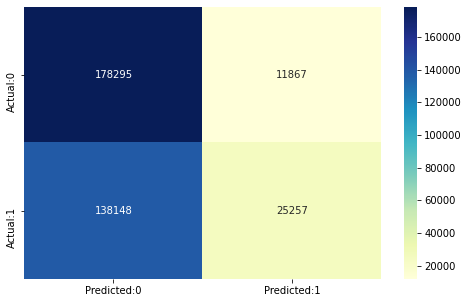

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
confmat = confusion_matrix(y_true=labels_df, y_pred=predictions_df)
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(predictions_df)

In [0]:
predictions.show()

+---+--------+-----+-------+----+-----------+-----------+------------------+--------------+-----------------+--------------------------+--------------+--------------------+-------------+------------------+-------------------------+-------------------------+---------------------------+---------------------------+----------------+-----------------+-------------+-------------+--------------+--------------+-----------+----------------+-------------+------------+----------------+--------------------+---------------------+--------------+-----------+-------------+-------------------+----------------+---------------+------------+---------------------+-----------------+-----------------+-------------------------+-------------------------+---------------+--------------------+-------------+-------------------+-------------+-------------+-----------+------------+-----------------+------------------------------+------------------+------------+------------+-----------------+-----------------------+-